In [34]:
from importlib import reload
from pyfvtool import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root
from tqdm import tqdm

import sys
sys.path.append('..')
from pymadreq import *
import pymadreq.coreflood as cf
import pymadreq.fractional_flow as ff
import pymadreq.IO as IO

reload(ff)
reload(cf)
reload(IO)

<module 'pymadreq.IO' from 'd:\\projects\\github\\PyMADREQ\\examples\\..\\pymadreq\\IO.py'>

## Reading input file and defining the domain

In [35]:
# read the input file
data = IO.read_json("../examples/sample.json")
rel_perm_ww, rel_perm_ow, pc_ww, pc_ow = IO.read_transport_functions(data)
core_plug = IO.read_core_properties(data)
fluids = IO.read_fluids(data)
IC = IO.read_initial_conditions(data) # initial conditions
BC = IO.createFloodingCondition(data["BC"]) # boundary conditions
numerical_params = IO.read_numerical_settings(data)
m = IO.read_flooding_domain(data)

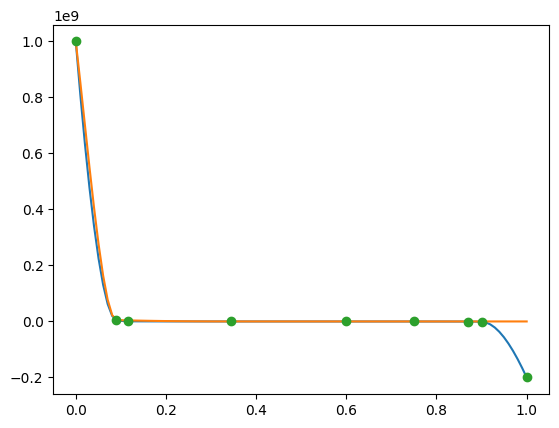

In [36]:
pc_ww.visualize()

In [37]:
cf_1d = cf.CoreFlooding1D(
    rel_perm_ww, pc_ww, core_plug, fluids, IC, BC, numerical_params, Nx=50
)

In [38]:
t_num, R_num, dp_num = cf_1d.simulate_no_pc()
t_num_pc, R_num_pc, dp_num_pc = cf_1d.simulate_with_pc()


## Transport properties

In [39]:
xt_shock, sw_shock, xt_prf, sw_prf, t_ana, p_inj_ana, R_oil_ana = ff.frac_flow_wf(
    fluids, rel_perm_ww, core_plug, IC, ut=cf_1d.u_inj, sw_inj=1.0, pv_inj=3.0)

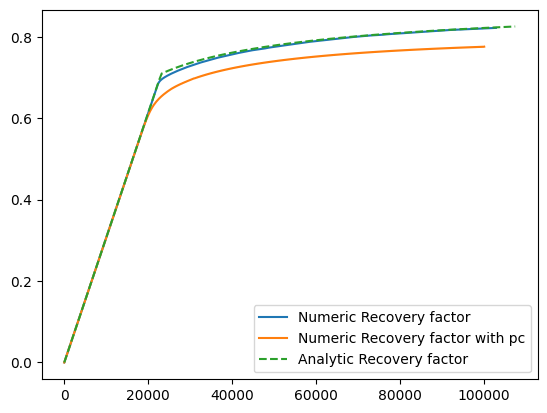

In [40]:
plt.plot(t_num, R_num, label= 'Numeric Recovery factor')
plt.plot(t_num_pc, R_num_pc, label= 'Numeric Recovery factor with pc')
plt.plot(t_ana, R_oil_ana, '--', label= 'Analytic Recovery factor')
plt.legend()

In [41]:
cf_1d.final_sw.value


array([1.15303097, 0.84696903, 0.84526209, 0.84359335, 0.84195837,
       0.8403533 , 0.83877477, 0.83721979, 0.83568562, 0.83416978,
       0.8326699 , 0.83118376, 0.8297092 , 0.82824407, 0.82678623,
       0.82533347, 0.82388351, 0.82243392, 0.82098212, 0.81952526,
       0.81806025, 0.81658362, 0.8150915 , 0.81357948, 0.81204256,
       0.81047498, 0.80887007, 0.80722012, 0.80551605, 0.80374722,
       0.80190101, 0.79996236, 0.79791318, 0.7957315 , 0.79339053,
       0.79085701, 0.78808956, 0.78503537, 0.78162771, 0.77777798,
       0.77337582, 0.76826708, 0.76228982, 0.75520142, 0.74697884,
       0.73691952, 0.72512207, 0.70855304, 0.6902502 , 0.65428889,
       0.63144638, 0.56855362])

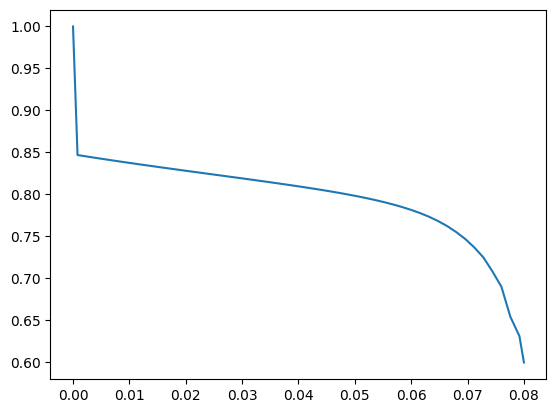

In [42]:
visualizeCells(cf_1d.final_sw)

## Fittin model to core flooding data

In [43]:
# using lmfit to fit a two-phase model to a dataset
from lmfit import minimize, Parameters
def residual(params, x, data):
    amp = params['amp']
    phaseshift = params['phase']
    freq = params['frequency']
    decay = params['decay']

    model = amp * np.sin(x*freq + phaseshift) * np.exp(-x*x*decay)

    return (data-model)


params = Parameters()
params.add('amp', value=10)
params.add('decay', value=0.007)
params.add('phase', value=0.2)
params.add('frequency', value=3.0)

out = minimize(residual, params, args=(x, data))

NameError: name 'x' is not defined